In [82]:
import pandas as pd
import xarray as xr
import numpy as np
import netCDF4

# matplotlib import
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D

# cartopy import
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature

# scipy import
from scipy.interpolate import griddata
from scipy.ndimage import convolve

#### Compute density track according to Neu & al (2013) description :
*Number of tracks passing a grid cell (with repeated entries of the same track being counted as one).*
#### But express density per 1000km2 instead of 0.25°x0.25°

In [36]:
def add_features():
    
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',  name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none', edgecolor='black', zorder=6)
    
    land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='black',
                                            facecolor='lightgray', zorder=4)
    
    lakes_50m = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='black', facecolor='none', zorder=7)
    
    lakes_50m_edge= cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                            edgecolor='black',
                                            facecolor='None',lw=1.2, zorder=9)

    ax.add_feature(land_50m)    
    ax.add_feature(lakes_50m)
    ax.add_feature(lakes_50m_edge)
    ax.add_feature(cfeature.BORDERS, zorder=6, edgecolor='black')  
    ax.add_feature(states_provinces)
    ax.coastlines('50m', zorder=7, color='black',lw=1.2)

In [37]:
def circ_krnl(radius) : 
    
    """
    
    Create a kernel (matrix). 
    (0,0) is the pixel of interest
    if (i,j) = 1, the pixel is at r distance from (0,0)
    if (i,j) = 0, the pixel is further.
    
    """
    
    # x, y : horizontal (vertical) 1D array with values from -9 to 9
    y, x = np.ogrid[-radius : radius + 1, -radius : radius + 1]
    
    # get rid of negative values and get pixels that are within the 
    # radius distance of (0,0)
    mask = x**2 + y**2 <= radius **2
    kernel = np.ones((2 * radius + 1, 2 * radius + 1))
    
    # Assign 1 to pixel if mask == True and 0 if False
    kernel[~mask] = 0
    return kernel

def circ_filt(array, radius) : 
    
    """
    
    Use convolve scipy function to calculate the average value
    of a pixel around a given radius (creates circular smoothing)
    
    """
    
    kernel = circ_krnl(radius)
    
    # normalize the kernel
    n_krnl = kernel / np.sum(kernel) 
    
    return convolve(array, n_krnl)

## Plot track density at each grid point

plotting for ...  JJA
plotting for ...  SON
plotting for ...  DJF
plotting for ...  MAM


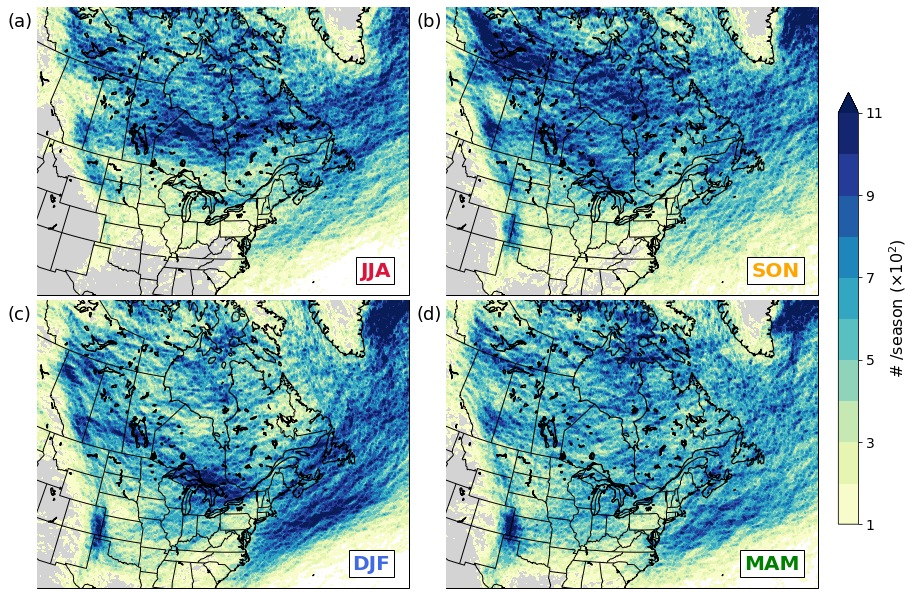

In [38]:
Track=netCDF4.Dataset('/pampa/cloutier/density/NAEC/Track_density_1979_2020_all_seasons.nc','r')

# create lists for iteration
seasons = ['JJA', 'SON', 'DJF', 'MAM']
colors = ['crimson', 'orange', 'royalblue', 'green']
index = ['(a)', '(b)', '(c)', '(d)']

i = 1
fig = plt.figure(figsize = (14, 12))
proj = ccrs.LambertConformal(central_longitude=-80, central_latitude=35, standard_parallels=[35])
extent = (-110, -50, 27.5, 67.3)

for szn, col, idx in zip(seasons, colors, index) : 
    lat0 = Track.variables['latitude'][:]
    lon0 = Track.variables['longitude'][:]
    den = Track.variables['trackDen_'+szn+''][:,:]/42 # 42 years total
    
    lon, lat = np.meshgrid(lon0, lat0)
    
    # create sub figures
    ax = fig.add_subplot(2, 2, i, projection=proj)
    i += 1
    extent=(-110, -50, 27.5, 67.3)
    add_features()
    ax.set_extent(extent)

    # Number of tracks per 1000km2
    den_area = (den * (1000**2)) / (np.cos(np.radians(lat)) * (111.3 * 0.25)**2)
    den_freq = den_area / 
    
    levels=[1,2,3,4,5,7,9,11,13]
    print('plotting for ... ', szn)
    contour = ax.contourf(lon, lat, den_area, transform=ccrs.PlateCarree(), 
                          zorder=5, cmap=plt.cm.get_cmap('YlGnBu'), levels=np.arange(1,12), extend='max')
    
    ax.spines['geo'].set_linewidth(1)
    
    ax.text(0.95, 0.05, szn, transform=ax.transAxes, ha='right', va='bottom', 
            bbox=dict(facecolor='white', edgecolor='black'), fontsize=20, zorder=16, fontweight ='bold', color=col)
    
    fig.text(-0.08, 0.98, idx, transform=ax.transAxes, ha='left', va='top', fontsize=18)


# Create a colorbar next to the figure
# Value 1 : x coordinate (move left and right)
# value 2 : y coordinate (move up and down)
# Value 3 : Width 
# value 4 : height (in terms of % of the figure)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.5])  # Adjust the position and size as needed
cbar = fig.colorbar(contour, cax=cbar_ax)

cbar.set_label(label=r'# /season ($\times 10^{2}$)', size=16)
cbar.ax.tick_params(labelsize=14)

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.01, top=0.8, wspace = 0.1)
#fig.text(0.33, 0.85, 'Average track density per area of 1000 km$^{2}$', va='top', fontsize=16)
plt.savefig('/pampa/cloutier/fig/track_den_1000km2.png', dpi=300)

plt.show()

Track.close()

## Plot track density at each grid point with smoothing

<ipython-input-44-9c68ebed6f42>:64: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('/pampa/cloutier/fig/track_den_1000km2_smooth.png', dpi=300, bbox_inches='tight', figsize=(14,12))


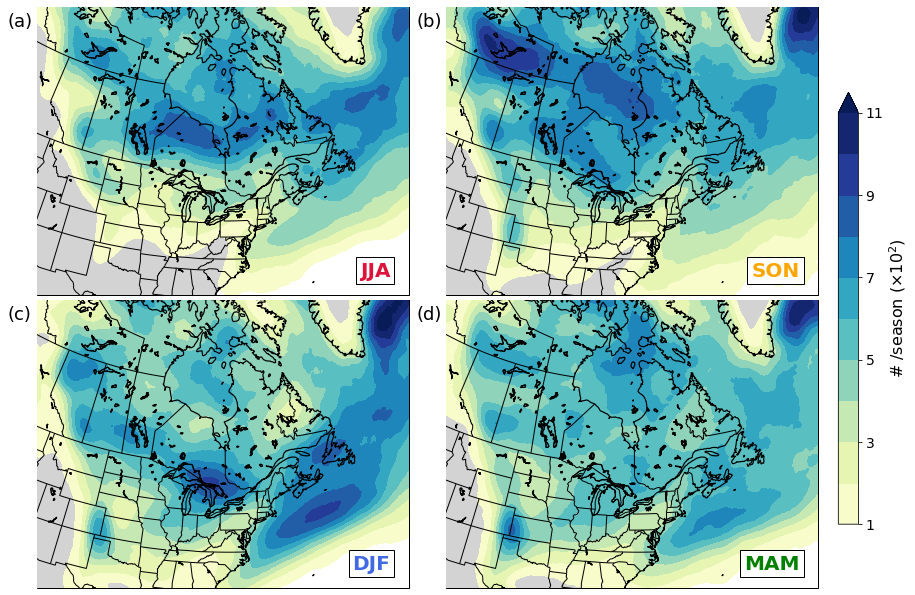

In [44]:
Track=netCDF4.Dataset('/pampa/cloutier/density/NAEC/Track_density_1979_2020_all_seasons.nc','r')

# create lists for iteration
seasons = ['JJA', 'SON', 'DJF', 'MAM']
colors = ['crimson', 'orange', 'royalblue', 'green']
index = ['(a)', '(b)', '(c)', '(d)']

i = 1
fig = plt.figure(figsize = (14, 12))
proj = ccrs.LambertConformal(central_longitude=-80, central_latitude=35, standard_parallels=[35])
extent = (-110, -50, 27.5, 67.3)

# radius in pixel for smoothing
r = 9

for szn, col, idx in zip(seasons, colors, index) : 
    lat0 = Track.variables['latitude'][:]
    lon0 = Track.variables['longitude'][:]
    den = Track.variables['trackDen_'+szn+''][:,:]/42
    
    lon, lat = np.meshgrid(lon0, lat0)
    
    # create sub figures
    ax = fig.add_subplot(2, 2, i, projection=proj)
    i += 1
    extent=(-110, -50, 27.5, 67.3)
    add_features()
    ax.set_extent(extent)

    # Number of tracks per 1000km2
    den_area = (den * (1000**2)) / (np.cos(np.radians(lat)) * (111.3 * 0.25)**2)
    den_area = den_area / 100
    
    # adding circular filter for smoothing
    den_filt = circ_filt(den_area, r)
    
    #print('plotting for ... ', szn)
    contour = ax.contourf(lon, lat, den_filt, transform=ccrs.PlateCarree(), 
                          zorder=5, cmap=plt.cm.get_cmap('YlGnBu'), levels=np.arange(1,12), extend='max')
    
    ax.spines['geo'].set_linewidth(1)
    
    ax.text(0.95, 0.05, szn, transform=ax.transAxes, ha='right', va='bottom', 
            bbox=dict(facecolor='white', edgecolor='black'), fontsize=20, zorder=16, fontweight ='bold', color=col)
    
    fig.text(-0.08, 0.98, idx, transform=ax.transAxes, ha='left', va='top', fontsize=18)


# Create a colorbar next to the figure
# Value 1 : x coordinate (move left and right)
# value 2 : y coordinate (move up and down)
# Value 3 : Width 
# value 4 : height (in terms of % of the figure)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.5])  # Adjust the position and size as needed
cbar = fig.colorbar(contour, cax=cbar_ax)

cbar.set_label(label=r'# /season ($\times 10^{2}$)', size=16)
cbar.ax.tick_params(labelsize=14)

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.01, top=0.8, wspace = 0.1)
#fig.text(0.3, 0.85, 'Average track density per area of 1000 km$^{2}$', va='top', fontsize=16)

plt.savefig('/pampa/cloutier/fig/track_den_1000km2_smooth.png', dpi=300, bbox_inches='tight', figsize=(14,12))

plt.show()

Track.close()

#### Compute density track according to Chen & al (2022) :
*Number of tracks passing a grid cell within a 250km radius(with repeated entries of the same track being counted as one).*

plotting for ...  JJA
plotting for ...  SON
plotting for ...  DJF
plotting for ...  MAM


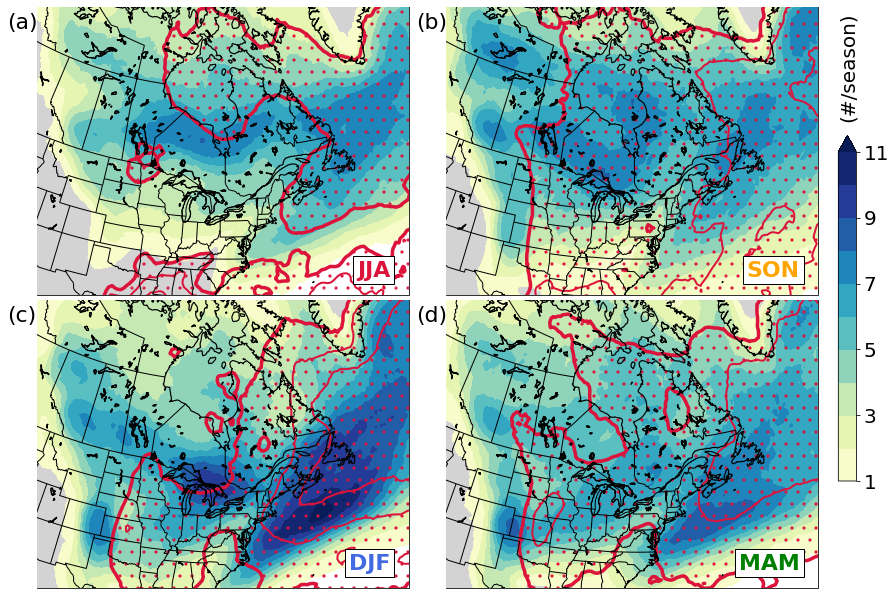

In [63]:
Track  = netCDF4.Dataset('/pampa/cloutier/density/NAEC/Track_density_1979_2020_all_seasons_250km.nc','r')
Track2 = netCDF4.Dataset('/pampa/cloutier/density/NAEC/Track_intensity_1979_2020_all_seasons_250km.nc','r')

# create lists for iteration
seasons = ['JJA', 'SON', 'DJF', 'MAM']
colors = ['crimson', 'orange', 'royalblue', 'green']
index = ['(a)', '(b)', '(c)', '(d)']

plt.rcParams['hatch.linewidth'] = 0.7
plt.rcParams['hatch.color'] = 'crimson'


i = 1
fig = plt.figure(figsize = (14, 12))
proj = ccrs.LambertConformal(central_longitude=-80, central_latitude=35, standard_parallels=[35])
extent = (-110, -50, 27.5, 67.3)

for szn, col, idx in zip(seasons, colors, index) : 
    lat0 = Track.variables['latitude'][:]
    lon0 = Track.variables['longitude'][:]
    den = Track.variables['trackDen_'+szn+''][:,:]/42
    
    lat1 = Track2.variables['latitude'][:]
    lon1 = Track2.variables['longitude'][:]
    inten = Track2.variables['trackInt_'+szn+''][:,:]
    
    lonD, latD = np.meshgrid(lon0, lat0)
    lonI, latI = np.meshgrid(lon1, lat1)
    
    # create sub figures
    ax = fig.add_subplot(2, 2, i, projection=proj)
    i += 1
    extent=(-110, -50, 27.5, 67.3)
    add_features()
    ax.set_extent(extent)
    
    print('plotting for ... ', szn)
    
    # Density plot
    contour1 = ax.contourf(lonD, latD, den, transform=ccrs.PlateCarree(), 
                          zorder=5, cmap=plt.cm.get_cmap('YlGnBu'), levels=np.arange(1,12), extend='max')
    
    # Intensity plot (scatter)                                    
    contour2 = ax.contourf(lonI, latI, inten, transform=ccrs.PlateCarree(), zorder=6,
                     levels=np.arange(7,16),
                     hatches=['.'],colors='None')
    
   # Intensity plot (contour lines)                         
    contour2 = ax.contour(lonI, latI, inten, transform=ccrs.PlateCarree(), zorder=6,colors='crimson',
                     linewidths=2.,levels=[7,9,11,13,15])
    
    # Intensity plot (boundary lines)                                    
    contour2 = ax.contour(lonI, latI, inten, transform=ccrs.PlateCarree(), zorder=6,colors='crimson',
                     linewidths=3.5,levels=[7])
    
    ax.text(0.95, 0.05, szn, transform=ax.transAxes, ha='right', va='bottom', 
            bbox=dict(facecolor='white', edgecolor='black'), fontsize=22, zorder=16, fontweight ='bold', color=col)
    
    fig.text(-0.08, 0.98, idx, transform=ax.transAxes, ha='left', va='top', fontsize=22)


# Create a colorbar next to the figure
cbar_ax = fig.add_axes([0.92, 0.25, 0.018, 0.4])  # Adjust the position and size as needed
cbar = fig.colorbar(contour1, cax=cbar_ax)

#cbar.set_label(label=r'(# /season)', size=16, loc='top')
fig.text(0.92, 0.67, '(#/season)', rotation=90, fontsize=20)
cbar.ax.tick_params(labelsize=20)

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.01, top=0.8, wspace = 0.1)
#fig.text(0.25, 0.85, 'Average track density and intensity around a 250 km radius', va='top',fontsize=16)
plt.savefig('/pampa/cloutier/fig/track_den_inten_250km.png', dpi=300, bbox_inches='tight')

plt.show()
Track.close()
Track2.close()

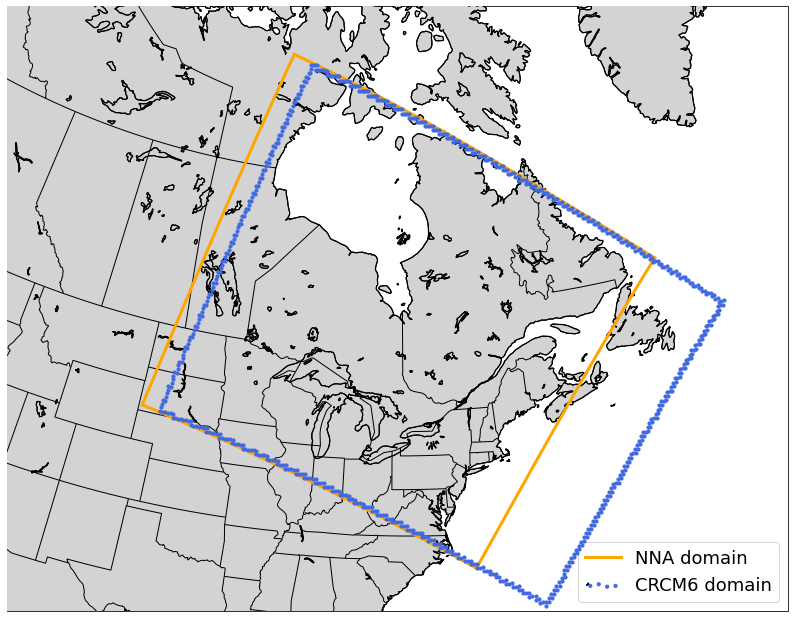

In [107]:

fig = plt.figure(figsize = (14, 12))
proj = ccrs.LambertConformal(central_longitude=-80, central_latitude=35, standard_parallels=[35])

DomChen = netCDF4.Dataset('/home/chen/codes/2p5kmDomain/var_MG_free_grid_date.nc3','r')
df = pd.read_csv('/pampa/cloutier/outline_crcm6_domain.csv')

ax = fig.add_subplot(1, 1, 1, projection=proj)
i += 1
extent=(-110, -50, 27.5, 67.3)
add_features()
ax.set_extent(extent)

latChen = DomChen.variables['lat'][:,:]
lonChen = DomChen.variables['lon'][:,:]

# Créer une liste arbitraire 
latD = df['lat']
lonD = df['lon']

# crcm6 domain
bnd=ax.scatter(lonD, latD, zorder=15, transform=ccrs.PlateCarree(), s=10, color='royalblue', label = 'CRCM6 domain')

# NNA domain
cf2=plt.plot(lonChen[0,:],latChen[0,:],c='orange', lw=3,transform=ccrs.PlateCarree(),zorder=10, label='NNA domain')
cf2=plt.plot(lonChen[:,0],latChen[:,0],c='orange',lw=3,transform=ccrs.PlateCarree(),zorder=10)
cf2=plt.plot(lonChen[-1,:],latChen[-1,:],c='orange',lw=3,transform=ccrs.PlateCarree(),zorder=10)
cf2=plt.plot(lonChen[:,-1],latChen[:,-1],c='orange',lw=3,transform=ccrs.PlateCarree(),zorder=10)

ax.legend(loc='lower right', fontsize=18, scatterpoints = 4)

plt.savefig('/pampa/cloutier/fig/comp_dom_chen_crcm6.png', dpi=300, bbox_inches='tight')

plt.show()

In [108]:
latD.min()

31.25

In [85]:
latD.max()

66.25

In [86]:
lonD.min()

258.0

In [87]:
lonD.max()

313.0

In [91]:
df.loc[df.lon == 313]

,Unnamed: 0,lat,lon,HU
366,18307,48.75,313.0,True
